# Example GEV Analysis (Part I)

Matthew Walker, Leroy Bird, [Kanute](kanute.com).  2021-11-12.

In part one of this two-part series, we use artificial normally-distributed data to demonstrate how to fit a [Generalized Extreme Value (GEV) distribution](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution).  We then produce a return-period plot, showing both the observed data and the GEV fit.

For the latest version of this tutorial, please see [the GitHub repository](https://github.com/kanute-climate/gev-tutorial).

In [1]:
import numpy as np
import seaborn as sns
import scipy

rng = np.random.default_rng()

## Artifical Dataset

Let's produce an artificial dataset by sampling from the standard normal distribution.  Ensuring that the dataset is very large will make our histograms smooth and give us visual confidence when we fit the GEV distribution.

Let's say we sample a value every day.

In [2]:
# Create an artifical dataset by sampling from the normal distribution.
days_per_year = 365
years_in_sample = 10000
total_number_of_samples = days_per_year*years_in_sample
samples = rng.standard_normal(total_number_of_samples)

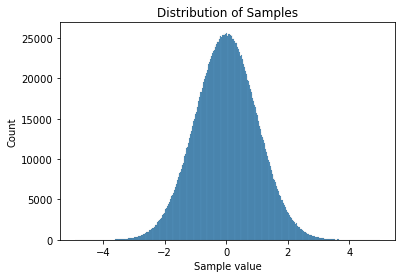

In [3]:
# Plot a histogram of the dataset
ax = sns.histplot(samples)
ax.set_title("Distribution of Samples")
ax.set_xlabel("Sample value")
None # don't return a value

## Block Maxima

Once we have our data, we divide it into blocks.  We then find the maximum value that occurs in each block.  This new series is called the block maxima.

In our example, we'll consider blocks of 365 simulated days.

In [4]:
# Calculate the block maxima
block_size = days_per_year
num_blocks = np.floor(len(samples) / block_size)
blocks = np.split(samples, num_blocks)
block_maxima = np.max(blocks, axis=1)

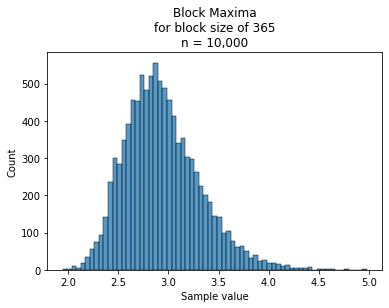

In [5]:
# Plot a histogram of the block maxima
ax = sns.histplot(block_maxima)
ax.set_title(
    f"Block Maxima\n"
    +f"for block size of {block_size}\n"
    +f"n = {len(block_maxima):,d}"
)
ax.set_xlabel("Sample value")
None # Don't return a value

## GEV Fit

We next fit a GEV distribution to the block maxima and then plot the fitted GEV distribution on top of the histogram of the block maxima.

In [6]:
# GEV fit
params = scipy.stats.genextreme.fit(block_maxima)
shape, location, scale = params
print("The fitted GEV distribution has the parameters:")
print(" - shape:", shape)
print(" - location:", location)
print(" - scale:", scale)

The fitted GEV distribution has the parameters:
 - shape: 0.09052247799408455
 - location: 2.779110631374887
 - scale: 0.3238557618037209


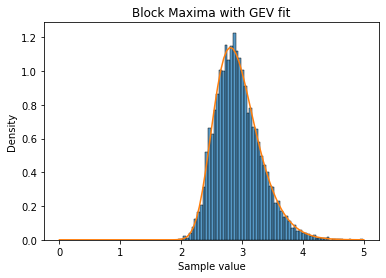

In [7]:
# Plot a histogram of the block maxima
ax = sns.histplot(block_maxima, stat="density")

# Plot the fitted GEV curve
x2 = np.linspace(0,5, 101)
y = scipy.stats.genextreme.pdf(x2, *params)
line_color = [sns.color_palette(n_colors=2, as_cmap=True)[1]]
sns.lineplot(x=x2, y=y, hue=0, palette=line_color, legend=False)

ax.set_title("Block Maxima with GEV fit")
ax.set_xlabel("Sample value")
None # Don't return a value

## Cumulative Distribution Function (CDF)

The Probability Density Function (PDF) of the GEV fit (above) can also be viewed as a Cumulative Distribution Function (CDF).  Although this step isn't necessary, it will help our understanding in the next steps.

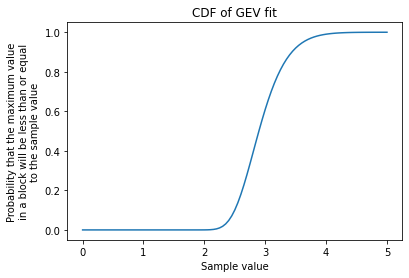

In [8]:
x = np.linspace(0,5, 101)
y = scipy.stats.genextreme.cdf(x, *params)
ax = sns.lineplot(x=x, y=y)

ax.set_title("CDF of GEV fit")
ax.set_xlabel("Sample value")
ax.set_ylabel(
    "Probability that the maximum value\n"
    +"in a block will be less than or equal\n"
    +"to the sample value"
)
None # Don't return a value

## Percent Point Function (PPF) - Inverse of CDF

We can inverse the CDF using the `ppf()` function: this allows us to find the sample value for a given probability.  We can compare this value for the GEV fit with the same quantile of the block maxima.

In [9]:
proportion = 0.99
value = scipy.stats.genextreme.ppf(0.99, *params)
print(
    f"From the GEV fit, we would expect {proportion*100}% of the block maxima\n"
    +f"to be less than or equal to {value}."
)

From the GEV fit, we would expect 99.0% of the block maxima
to be less than or equal to 3.9976317954741774.


In [10]:
value = np.quantile(block_maxima, proportion)
print(
    f"From the large set of block maxima, we found that {proportion*100}% have a\n"
    f"value less than or equal to {value}."
)

From the large set of block maxima, we found that 99.0% have a
value less than or equal to 4.009295955476129.


## Return-Periods

Inversing a probability gives how long you'd expect to wait before that event occurs, we call this value the "return period".  For example if we have a probability of 50% that something happens each year, then we would expect it to happen, on average, every two years (1/0.5 = 2).

In the code below, we specify the return period.  From that we calculate the inverse of the return period (the probability of the event occurring).  We then use the `ppf()` function to look up the maximum value we can expect for the specified return period. 

In [11]:
# What's the maximum sample value that we could expect for a given number of years?
return_period = 100 # year
inverse_return_period = 1/return_period # 1-in-x years
y_value = 1-inverse_return_period # y-value on the CDF plot
event_size = scipy.stats.genextreme.ppf(y_value, *params)
print(
    f"In a 1-in-{return_period} event, we would expect to see\n"
    +f"a maximum value in a block of {event_size}."
)

In a 1-in-100 event, we would expect to see
a maximum value in a block of 3.9976317954741774.


## Return-Period Plot

The return-period plot is just a plot of the PPF, but with the probabilities inversed to give a return period.  Note that the return-period axis is often plotted on a log scale.

In [12]:
# Calculate the values for the x-axis
# The value 10^0=1 may not be well defined, so we start with a value slightly larger than that.
return_periods = np.logspace(0.00001, 3, 100)

# Calculate the values for the y-axis
probabilities = 1-(1/return_periods)
event_sizes = scipy.stats.genextreme.ppf(probabilities, *params)

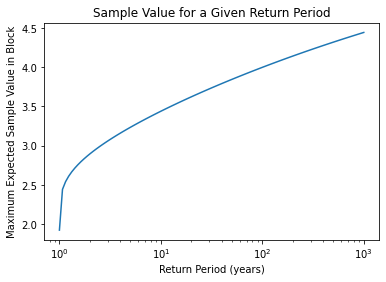

In [13]:
# Create the return-period plot
ax = sns.lineplot(x=return_periods, y=event_sizes)

# Set plot's attributes
ax.set(xscale="log")
ax.set_title("Sample Value for a Given Return Period") 
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Maximum Expected Sample Value in Block")
None # Don't return a value

## CDF and Observed Data

We can also add our observed block maxima to the above plot, but it's easiest to first imagine that we recreate the earlier CDF plot with our observed data.  To do so we'd sort our block maxima and plot their values along the x-axis and their quantiles on the y-axis.

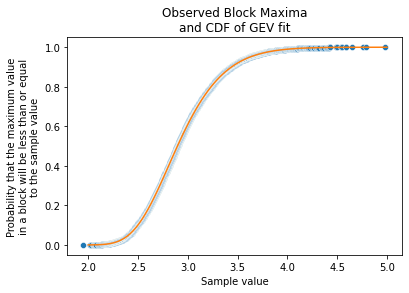

In [14]:
# Plot the observed block maxima
block_maxima_sorted = sorted(block_maxima)
proportion_at_or_below = np.arange(1, len(block_maxima)+1) / len(block_maxima)
ax = sns.scatterplot(
    x=block_maxima_sorted, 
    y=proportion_at_or_below
)

# Plot the GEV fit
line_color = [sns.color_palette(n_colors=2, as_cmap=True)[1]]
x = np.linspace(2,5, 101)
y = scipy.stats.genextreme.cdf(x, *params)
ax = sns.lineplot(x=x, y=y, palette=line_color, hue=0, legend=False)

# Set the plot's attributes
ax.set_title("Observed Block Maxima\nand CDF of GEV fit")
ax.set_xlabel("Sample value")
ax.set_ylabel(
    "Probability that the maximum value\n"
    +"in a block will be less than or equal\n"
    +"to the sample value"
)
None # Don't return a value

## Return-Period Plot and Observed Data

Now that we have the sorted block maxima and their quantiles, we can transform them to the return period plot we generated earlier.

We elect to modify the proportions slightly.  The rationale is that the very largest value was indeed observed once in our dataset.  As an extension exercise, consider what would happen to our largest value if we used `proportion_at_or_below` rather than `proportion_at_or_above`.

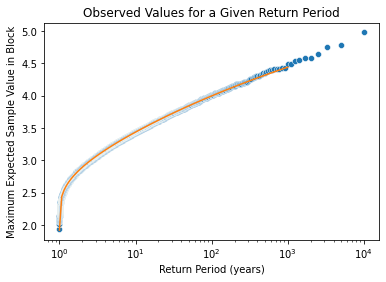

In [15]:
# Calculate the proportion of samples at or above the given block maxima
# This is similar to proportion_at_or_below.  Where proportion_at_or_below was 1.0
# for the most extreme value, proportion_at_or_above is 1/len(block_maxima).
proportion_at_or_above = np.arange(len(block_maxima), 0, step=-1) / len(block_maxima)

# Calculate the observed return periods
return_periods_observed = 1/proportion_at_or_above

# Plot the observed block maxima
ax = sns.scatterplot(
    x=return_periods_observed,
    y=block_maxima_sorted
)

# Plot the GEV fit
line_color = [sns.color_palette(n_colors=2, as_cmap=True)[1]]
ax = sns.lineplot(
    x=return_periods, 
    y=event_sizes, 
    palette=line_color, hue=0, legend=False
)

# Set the plot's attributes
ax.set(xscale="log")
ax.set_title("Observed Values for a Given Return Period") 
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Maximum Expected Sample Value in Block")
None # Don't return a value

## TL;DR

A GEV analysis requires that you:

1. Obtain your data.

2. Calculate the block maxima.

3. Fit the GEV curve using `scipy.stats.genextreme.fit()`.

You can then use the following function to create a return period plot.

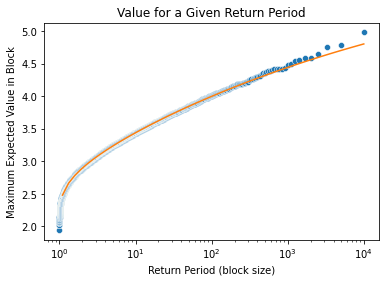

In [16]:
def return_period_plot(gev_params, block_maxima=None, return_period_range=None, plot_observed=None):
    """ Produces a return-period plot given a GEV fit.
    
    Args:
        gev_params: a tuple giving the shape, location, and scale of the GEV fit.
        block_maxima: a list-like containing the maximum values for the blocks used for the GEV fit.
        return_period_range: a two-item tuple or list containing the minimum and maximum values
          for the x-axis.
        plot_observed: a boolean indicating whether to plot the observed values (block_maxima).
        
    Returns:
        A matplotlib axes for the plot.
    
    """
    # Set plot_observed if it wasn't set but block maxima were passed in.
    if plot_observed is None and block_maxima is not None:
        plot_observed = True
    
    # Plot the observed block maxima
    if plot_observed:
        if block_maxima is None:
            raise Exception("When plot_observed is set, block_maxima must be passed in.")
            
        # Sort the block maxima
        block_maxima_sorted = sorted(block_maxima)

        # Calculate the proportion of samples at or above the given block maxima
        proportion_at_or_above = np.arange(len(block_maxima), 0, step=-1) / len(block_maxima)

        # Calculate the observed return periods
        return_periods_observed = 1/proportion_at_or_above

        # Plot the observed block maxima
        sns.scatterplot(
            x=return_periods_observed, 
            y=block_maxima_sorted
        )

    if return_period_range is not None:
        return_period_lower = return_period_range[0]
        return_period_upper = return_period_range[1]
    else:
        if block_maxima is None:
            raise Exception("Either block_maxima or return_period_range must be passed.")
        return_period_lower = 1/len(block_maxima)
        return_period_upper = len(block_maxima)
    # Calculate the range of return periods
    return_periods = np.logspace(
        np.log10(return_period_lower), 
        np.log10(return_period_upper),
        num=100
    )

    # Get points from GEV fit
    probabilities = 1-(1/return_periods)
    event_sizes = scipy.stats.genextreme.ppf(probabilities, *gev_params)
        
    # Plot the GEV fit
    line_color = [sns.color_palette(n_colors=2, as_cmap=True)[1]]
    ax = sns.lineplot(
        x=return_periods, 
        y=event_sizes, 
        palette=line_color, hue=0, legend=False
    )

    # Set the plot's attributes
    ax.set(xscale="log")
    ax.set_title("Value for a Given Return Period") 
    ax.set_xlabel("Return Period (block size)")
    ax.set_ylabel("Maximum Expected Value in Block")
    return ax
    
ax = return_period_plot(params, block_maxima)